In [1]:
!pip install numpy pandas matplotlib scikit-learn tensorflow


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [3]:
np.random.seed(42)

time = np.arange(0, 500)
data = np.sin(0.02 * time) + np.random.normal(0, 0.1, size=len(time))

df = pd.DataFrame({"value": data})
df.head()


,value
0,0.049671
1,0.006172
2,0.104758
3,0.212267
4,0.056499


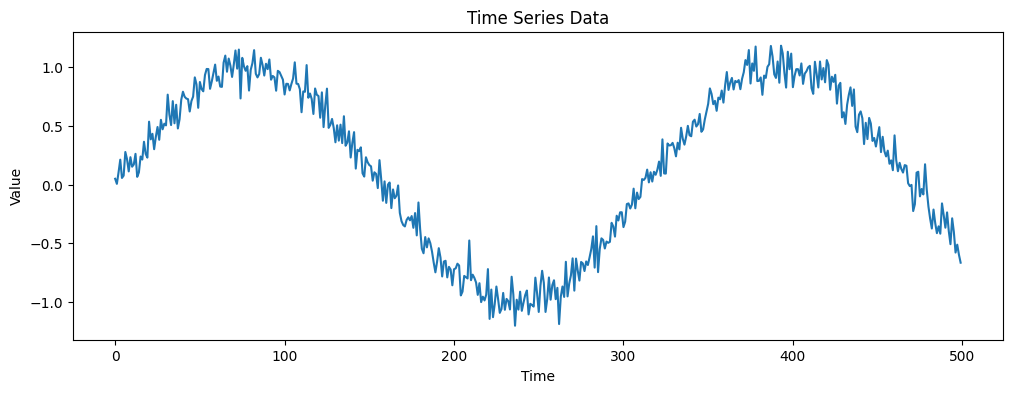

In [4]:
plt.figure(figsize=(12, 4))
plt.plot(df["value"])
plt.title("Time Series Data")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()


In [5]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)


In [6]:
def create_sequences(data, window_size=20):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)


In [7]:
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [8]:
model = Sequential([
    LSTM(50, activation="tanh", input_shape=(X_train.shape[1], 1)),
    Dense(1)
])

model.compile(
    optimizer="adam",
    loss="mse"
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.3445 - val_loss: 0.1702
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0369 - val_loss: 0.0189
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0209 - val_loss: 0.0251
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0114 - val_loss: 0.0076
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0070 - val_loss: 0.0025
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0044 - val_loss: 0.0031
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0039 - val_loss: 0.0025
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0

In [10]:
y_pred = model.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 


In [11]:
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print("RMSE:", rmse)


RMSE: 0.1364712971730111


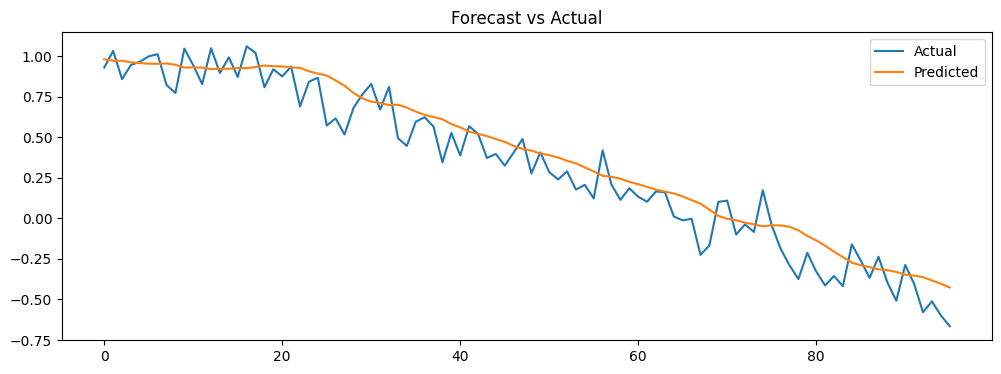

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred_inv, label="Predicted")
plt.legend()
plt.title("Forecast vs Actual")
plt.show()


In [13]:
errors = np.abs(y_test_inv - y_pred_inv)

threshold = np.mean(errors) + 2 * np.std(errors)
anomalies = errors > threshold


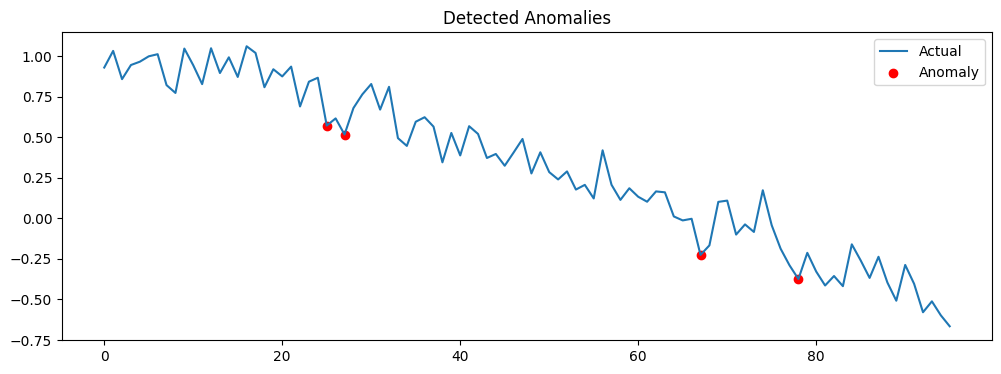

In [14]:
plt.figure(figsize=(12, 4))
plt.plot(y_test_inv, label="Actual")
plt.scatter(
    np.where(anomalies)[0],
    y_test_inv[anomalies],
    color="red",
    label="Anomaly"
)
plt.legend()
plt.title("Detected Anomalies")
plt.show()


In [17]:
# Conclusion
# - LSTM successfully forecasted time-series data
# - Prediction errors were used for anomaly detection
# - This approach is scalable to real-world sensor and financial data
